# Exploratory Data Analysis Pt 1

## Music Extraction Features

At this point I've completed constructing my db and now I want to get to know the data provided to me by Essentia and its models

In this first part of the EDA, I'm looking at the data produced by essentia's [Music Extractor tool](https://essentia.upf.edu/streaming_extractor_music.html)

In [24]:
#Imports
import os
import sqlite3
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from glob import glob
from tqdm import tqdm
import pathlib
import librosa
import taglib
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")

In [25]:
#Imports from project package called project_tools
from project_tools.utils import adapt_array, convert_array, tag_cleaner, json_opener

In [26]:
#Register these functions with sqlite3 so that we I can work with 
sqlite3.register_adapter(np.ndarray, adapt_array)
sqlite3.register_converter("array", convert_array)

In [27]:
#Connect to db
conn = sqlite3.connect("../jaage.db", detect_types= sqlite3.PARSE_DECLTYPES)
cur = conn.cursor()

Here are the tables in my database

In [28]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()
tables

[('effnet_embeddings',),
 ('tonal_features',),
 ('lowlevel_features',),
 ('rhythm_features',),
 ('approachability_2c_effnet_discogs_1_activations',),
 ('danceability_effnet_discogs_1_activations',),
 ('engagement_2c_effnet_discogs_1_activations',),
 ('genre_electronic_effnet_discogs_1_activations',),
 ('mood_acoustic_effnet_discogs_1_activations',),
 ('mood_aggressive_effnet_discogs_1_activations',),
 ('mood_happy_effnet_discogs_1_activations',),
 ('mood_party_effnet_discogs_1_activations',),
 ('mood_sad_effnet_discogs_1_activations',),
 ('mtg_jamendo_genre_effnet_discogs_1_activations',),
 ('mtg_jamendo_moodtheme_effnet_discogs_1_activations',),
 ('mtg_jamendo_top50tags_effnet_discogs_1_activations',),
 ('timbre_effnet_discogs_1_activations',),
 ('lowlevel_barkbands_mean_tbl',),
 ('lowlevel_barkbands_stdev_tbl',),
 ('lowlevel_erbbands_mean_tbl',),
 ('lowlevel_erbbands_stdev_tbl',),
 ('lowlevel_gfcc_mean_tbl',),
 ('lowlevel_melbands_mean_tbl',),
 ('lowlevel_melbands_stdev_tbl',),
 ('lo

The point of this notebook is essentially kick the tires on this dataset, basically audit what's available.

**Files**

In [29]:
files = pd.read_sql_query("SELECT * FROM files", con = conn)
files.head()

,sid,file_path
0,b806881a54bdbf9dd93a290716adf191,/Volumes/LaCie/Collection/04 House Of Love_PN.wav
1,46e54d2ab920a088b77382e04877141b,/Volumes/LaCie/Collection/Alex Virgo - Rough N...
2,a204ddef5763df6d8f7677701fe9d96f,/Volumes/LaCie/Collection/01 Protostar_PN.wav
3,960097894e83c5810a9c649f17a4e551,/Volumes/LaCie/Collection/Cristal - Drink My S...
4,a3c1f277aa0110ffc418bf5fa3aa16aa,/Volumes/LaCie/Collection/Maya - Lait De Coco ...


This table links the file paths of my music collection with the unique IDs generated by essentia's music features extraction tool

`sid` short for song id is the name unique id column for every table

### Music Extraction Features

**Tags**

In [30]:
tags = pd.read_sql_query("SELECT * FROM tags", con = conn).set_index("sid")
tags.head()

,length,gain,codec,file_name,bpm,initialkey,title,album,artist,date,genre,label
sid,,,,,,,,,,,,
b806881a54bdbf9dd93a290716adf191,287.393372,-9.895140,pcm_s16le,04 House Of Love_PN.wav,119.0,6A,04 House Of Love_PN,None,None,None,None,None
46e54d2ab920a088b77382e04877141b,311.251892,-11.281836,pcm_s16le,Alex Virgo - Rough N' Ready Edits - 06 A.T.S -...,128.0,1A,A.T.S - Baa Daa Laa (Alex Virgo's Rough n Read...,Rough N' Ready Edits,Alex Virgo,2020,None,None
a204ddef5763df6d8f7677701fe9d96f,415.114746,-9.958479,pcm_s16le,01 Protostar_PN.wav,117.0,5A,Protostar,Planetary Groove,FROM BEYOND,2020,None,None
960097894e83c5810a9c649f17a4e551,321.108765,-12.223524,pcm_s16le,Cristal - Drink My Soul (Running Hot Edit)_PN.wav,0.0,None,None,None,None,None,None,None
a3c1f277aa0110ffc418bf5fa3aa16aa,378.276276,-12.410757,pcm_s16le,Maya - Lait De Coco ( Les Yeux Orange Edit)_PN...,109.0,6A,Maya - Lait De Coco ( Les Yeux Orange Edit)_PN,None,None,2016,None,None


In [31]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3676 entries, b806881a54bdbf9dd93a290716adf191 to c907c2625a4b9ca8c4f82c47c130ca6a
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   length      3676 non-null   float64
 1   gain        3676 non-null   float64
 2   codec       3676 non-null   object 
 3   file_name   3676 non-null   object 
 4   bpm         3328 non-null   float64
 5   initialkey  2789 non-null   object 
 6   title       3601 non-null   object 
 7   album       1567 non-null   object 
 8   artist      2682 non-null   object 
 9   date        1115 non-null   object 
 10  genre       330 non-null    object 
 11  label       187 non-null    object 
dtypes: float64(3), object(9)
memory usage: 373.3+ KB


This table contains the metadata for the song collection such as important info like title, artist, bpm, and key

This data was collected using the music features extraction tool, but not generated by it. The metadata is already attached to the song file.

BPM Distribution

In [32]:
#Filter out 0 bpm
bpm = tags.query("bpm > 0").bpm

In [33]:
bpm.describe()

count    2746.000000
mean      117.554274
std         9.527769
min        70.000000
25%       114.000000
50%       120.000000
75%       124.000000
max       165.000000
Name: bpm, dtype: float64

This is pretty much to be expected for a DJ such as myself who plays house, funk, disco, and boogie

Visualize distribution

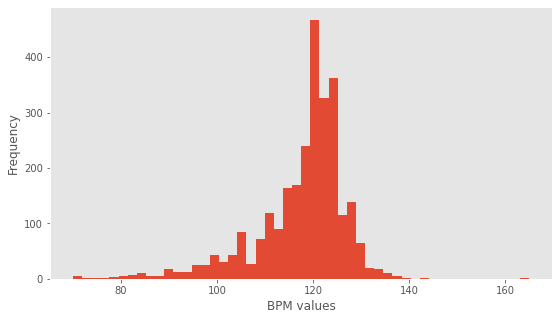

In [34]:
bpm.hist(bins = 50, figsize=(9, 5),grid = False)
plt.xlabel("BPM values")
plt.ylabel("Frequency");

Most common keys

In [35]:
keys = tags.initialkey.dropna()

In [36]:
keys.value_counts()

9A     372
8A     368
5A     297
4A     240
7A     238
6A     228
1A     151
2A     148
10A    140
11A    120
12A    105
3A      94
12B     25
8B      24
Fm      20
6B      20
9B      16
4B      16
7B      16
10B     14
3B      12
Em      12
11B     11
1B      11
Ebm      9
5B       9
Gm       8
F#m      8
Am       8
Bm       7
G#m      7
5b       7
Dm       6
Cm       6
Bbm      4
2B       4
7m       3
11m      1
7d       1
B        1
5m       1
C#m      1
Name: initialkey, dtype: int64

I use the camelot scale instead of the typical notation, which encodes song key and scale as numbers.

![](https://c.neevacdn.net/image/fetch/s--HF6z9snx--/https%3A//pyramind.com/wp-content/uploads/2020/05/preview-lightbox-CamelotWheel-1.jpg?savepath=preview-lightbox-CamelotWheel-1.jpg)

### Tonal features

In [37]:
tonal = pd.read_sql_query("SELECT * FROM tonal_features", index_col=['sid'], con = conn)
tonal.head()

,tonal_chords_changes_rate,tonal_chords_number_rate,tonal_chords_strength_mean,tonal_chords_strength_stdev,tonal_hpcp_crest_mean,tonal_hpcp_crest_stdev,tonal_hpcp_entropy_mean,tonal_hpcp_entropy_stdev,tonal_key_edma_strength,tonal_key_edma_key,...,tonal_key_krumhansl_scale,tonal_key_temperley_strength,tonal_key_temperley_key,tonal_key_temperley_scale,tonal_tuning_diatonic_strength,tonal_tuning_equal_tempered_deviation,tonal_tuning_frequency,tonal_tuning_nontempered_energy_ratio,tonal_chords_key,tonal_chords_scale
sid,,,,,,,,,,,,,,,,,,,,,
b806881a54bdbf9dd93a290716adf191,0.125525,0.001616,0.470475,0.069027,12.581001,5.755760,2.164732,0.779386,0.502125,C,...,major,0.520859,C,major,0.587632,0.150275,434.193115,0.881876,G,minor
46e54d2ab920a088b77382e04877141b,0.104863,0.002387,0.524884,0.118924,11.273207,5.629401,2.379997,0.772079,0.408560,D,...,major,0.424187,A,major,0.291458,0.197115,438.224518,0.868446,B,major
a204ddef5763df6d8f7677701fe9d96f,0.122595,0.001230,0.406664,0.095949,11.530407,7.164842,2.532152,0.983758,0.766319,E,...,major,0.760266,E,major,0.644248,0.140634,434.193115,0.818142,C,major
960097894e83c5810a9c649f17a4e551,0.043667,0.000868,0.559635,0.097361,12.221793,5.350279,2.142329,0.678882,0.653490,F,...,major,0.620772,F,major,0.530602,0.181902,434.193115,0.900062,C,minor
a3c1f277aa0110ffc418bf5fa3aa16aa,0.050448,0.001227,0.525044,0.089814,13.811895,5.832396,1.891747,0.636924,0.613022,G,...,minor,0.643362,G,minor,0.551057,0.006728,440.000000,0.687000,G,minor


In [38]:
tonal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3676 entries, b806881a54bdbf9dd93a290716adf191 to c907c2625a4b9ca8c4f82c47c130ca6a
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tonal_chords_changes_rate              3676 non-null   float64
 1   tonal_chords_number_rate               3676 non-null   float64
 2   tonal_chords_strength_mean             3676 non-null   float64
 3   tonal_chords_strength_stdev            3676 non-null   float64
 4   tonal_hpcp_crest_mean                  3676 non-null   float64
 5   tonal_hpcp_crest_stdev                 3676 non-null   float64
 6   tonal_hpcp_entropy_mean                3676 non-null   float64
 7   tonal_hpcp_entropy_stdev               3676 non-null   float64
 8   tonal_key_edma_strength                3676 non-null   float64
 9   tonal_key_edma_key                     3676 non-null   object 
 10  tonal_key_edma_sca

This description explains some of the features shown above:

**tuning_frequency**: estimated tuning frequency Hz

**hpcp**: 32-dimensional harmonic pitch class profile (HPCP) 

**hpcp_entropy**: Shannon entropy of a HPCP vector

**hpcp_crest**: crest of the HPCP vector.

**key_temperley, key_krumhansl, key_edma**; key estimation, its scale and strength using three different HPCP key profiles

**tuning_diatonic_strength**: key strength estimated from high-resolution HPCP (120 dimensions) using diatonic profile. 

At this point in my project, I'm not too familiar with this data nor do I have any immediate need to use. However I do believe that some time in the future it could yield benefits.

For now I am interested in key and scale features as potential alternatives to the metadata key and scale.

In [39]:
tonal.tonal_chords_key

sid
b806881a54bdbf9dd93a290716adf191    G
46e54d2ab920a088b77382e04877141b    B
a204ddef5763df6d8f7677701fe9d96f    C
960097894e83c5810a9c649f17a4e551    C
a3c1f277aa0110ffc418bf5fa3aa16aa    G
                                   ..
af51f580e59fa2d873d42e043e981ef0    B
357d0b315ae626a3ad32cc2511d551ca    D
a9d404dba70e33a5939cf3c494970a97    C
dbd2141abad87ed300faa84817882b4c    E
c907c2625a4b9ca8c4f82c47c130ca6a    D
Name: tonal_chords_key, Length: 3676, dtype: object

In [40]:
tonal.tonal_chords_scale

sid
b806881a54bdbf9dd93a290716adf191    minor
46e54d2ab920a088b77382e04877141b    major
a204ddef5763df6d8f7677701fe9d96f    major
960097894e83c5810a9c649f17a4e551    minor
a3c1f277aa0110ffc418bf5fa3aa16aa    minor
                                    ...  
af51f580e59fa2d873d42e043e981ef0    minor
357d0b315ae626a3ad32cc2511d551ca    minor
a9d404dba70e33a5939cf3c494970a97    major
dbd2141abad87ed300faa84817882b4c    minor
c907c2625a4b9ca8c4f82c47c130ca6a    minor
Name: tonal_chords_scale, Length: 3676, dtype: object

Let's convert these to camelot scale

In [41]:
key_dict = json_opener("../tonal_keys_dict.json")
keys = tonal.tonal_chords_key + tonal.tonal_chords_scale
keys = keys.map(key_dict)
tonal["camelot_scale_keys"] = keys

In [44]:
tonal.camelot_scale_keys.value_counts()

8A     321
5A     301
7A     278
9A     277
4A     276
8B     236
10A    232
12A    188
6A     177
9B     159
3A     145
11A    132
4B     128
7B     122
12B    106
11B    103
10B    102
3B      95
1A      91
2A      70
1B      63
5B      38
2B      36
Name: camelot_scale_keys, dtype: int64